In [3]:
#SciKit DSC540 HW1
'''created by Casey Bennett 2018, www.CaseyBennett.com'''

import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
'''Replace comment HERE'''
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


#############################################################################
#
# Global parameters
#
#####################

target_idx=0                                        #Index of Target variable
cross_val=1                                         #Control Switch for CV                                                                                                                                                      
norm_target=0                                       #Normalize target switch
norm_features=0                                     #Normalize target switch
binning=1                                           #Control Switch for Bin Target
bin_cnt=2                                           #If bin target, this sets number of classes
feat_select=1                                       #Control Switch for Feature Selection                                                                                   
fs_type=2                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)                        
lv_filter=0                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features
k_cnt=5                                             #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3

#Set global model parameters
rand_st=1                                           #Set Random State variable for randomizing splits on runs


#############################################################################
#
# Load Data
#
#####################

file1= csv.reader(open('noindexweirdtest2.csv'), delimiter=',', quotechar='"')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
print('\n')

data_np=np.asarray(data)
target_np=np.asarray(target)


#############################################################################
#
# Preprocess data
#
##########################################

if norm_target==1:
    #Target normalization for continuous values
    target_np=scale(target_np)

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)

'''if binning==1:
    #Discretize Target variable with KBinsDiscretizer
    enc = KBinsDiscretizer(n_bins=[bin_cnt], encode='ordinal', strategy='quantile')                         #Strategy here is important, quantile creating equal bins, but kmeans prob being more valid "clusters"
    target_np_bin = enc.fit_transform(target_np.reshape(-1,1))

    #Get Bin min/max
    temp=[[] for x in range(bin_cnt+1)]
    for i in range(len(target_np)):
        for j in range(bin_cnt):
            if target_np_bin[i]==j:
                temp[j].append(target_np[i])

    for j in range(bin_cnt):
        print('Bin', j, ':', min(temp[j]), max(temp[j]), len(temp[j]))
    print('\n')

    #Convert Target array back to correct shape
    target_np=np.ravel(target_np_bin)'''


#############################################################################
#
# Feature Selection
#
##########################################

#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=0.5)                                      #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=rand_st)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=3, criterion='mse', random_state=rand_st)
            sel = RFE(rgr, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model
        if binning==1:
            clf = GradientBoostingClassifier(n_estimators=100, loss='deviance', learning_rate=0.1, max_depth=2, min_samples_split=3, random_state=rand_st)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select: ')
        if binning==0:
            rgr = '''Unused in this homework'''
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select: ')
            
        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==3:
        if binning==1:                                                              ######Only work if the Target is binned###########
            #Univariate Feature Selection - Chi-squared
            sel=SelectKBest(chi2, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
            print ('Univariate Feature Selection - Chi2: ')
            sel_idx=fit_mod.get_support()

        if binning==0:                                                              ######Only work if the Target is continuous###########
            #Univariate Feature Selection - Mutual Info Regression
            sel=SelectKBest(mutual_info_regression, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected', temp)
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)
    
    

#############################################################################
#
# Train SciKit Models
#
##########################################

print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

####Classifiers####
if binning==1 and cross_val==0:
    #SciKit
    '''Test/Train split unused in this homework, skip down to CV section'''
 

                                                                                                                         
 
####Cross-Val Classifiers####
if binning==1 and cross_val==1:
    #Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}                                                                                                                
    
    #SciKit Gradient Boosting - Cross Val
    start_ts=time.time()
    clf=GradientBoostingClassifier(n_estimators=100, loss='deviance', learning_rate=0.1, max_depth=2, min_samples_split=3, random_state=rand_st)
    scores=cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)


    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Gradient Boosting Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
    print("Gradient Boosting AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)


    #SciKit Ada Boosting - Cross Val
    start_ts=time.time()
    clf=AdaBoostClassifier(n_estimators=100, base_estimator=None, learning_rate=0.1, random_state=rand_st)
    scores=cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)


    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Ada Boosting Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
    print("Ada Boosting AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)


    #SciKit Neural Network - Cross Val
    '''Replace comment HERE''' 

['home_outcome', 'stage', 'year', 'on_target_shot_home_team', 'on_target_shot_away_team', 'off_target_shot_home_team', 'off_target_shot_away_team', 'foul_home_team', 'foul_away_team', 'yellow_card_home_team', 'yellow_card_away_team', 'red_card_home_team', 'red_card_away_team', 'crosses_home_team', 'crosses_away_team', 'corner_home_team', 'corner_away_team', 'possession_home_team', 'possession_away_team', 'starplayer_Away', 'starplayer_Home', 'starplayer_No']
3030 3030


--FEATURE SELECTION ON-- 

Wrapper Select: 
Selected ['red_card_home_team', 'red_card_away_team', 'crosses_home_team', 'crosses_away_team', 'possession_home_team', 'possession_away_team', 'starplayer_Away', 'starplayer_Home']
Features (total/selected): 21 8


--ML Model Output-- 

Gradient Boosting Acc: 0.65 (+/- 0.07)
Gradient Boosting AUC: 0.72 (+/- 0.08)
CV Runtime: 0.5934135913848877
Ada Boosting Acc: 0.65 (+/- 0.07)
Ada Boosting AUC: 0.72 (+/- 0.08)
CV Runtime: 1.0731308460235596


In [4]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

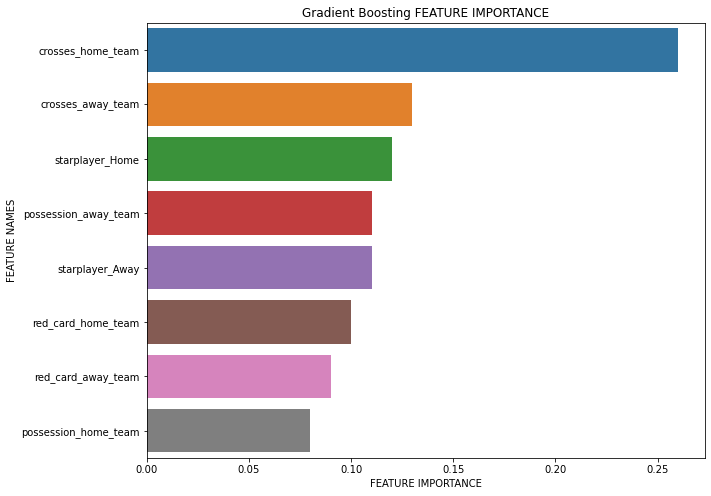

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_feature_importance(clf.fit(data_np, target_np).feature_importances_,header[1:15],'Gradient Boosting')